In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#import shapefile

Populating the interactive namespace from numpy and matplotlib


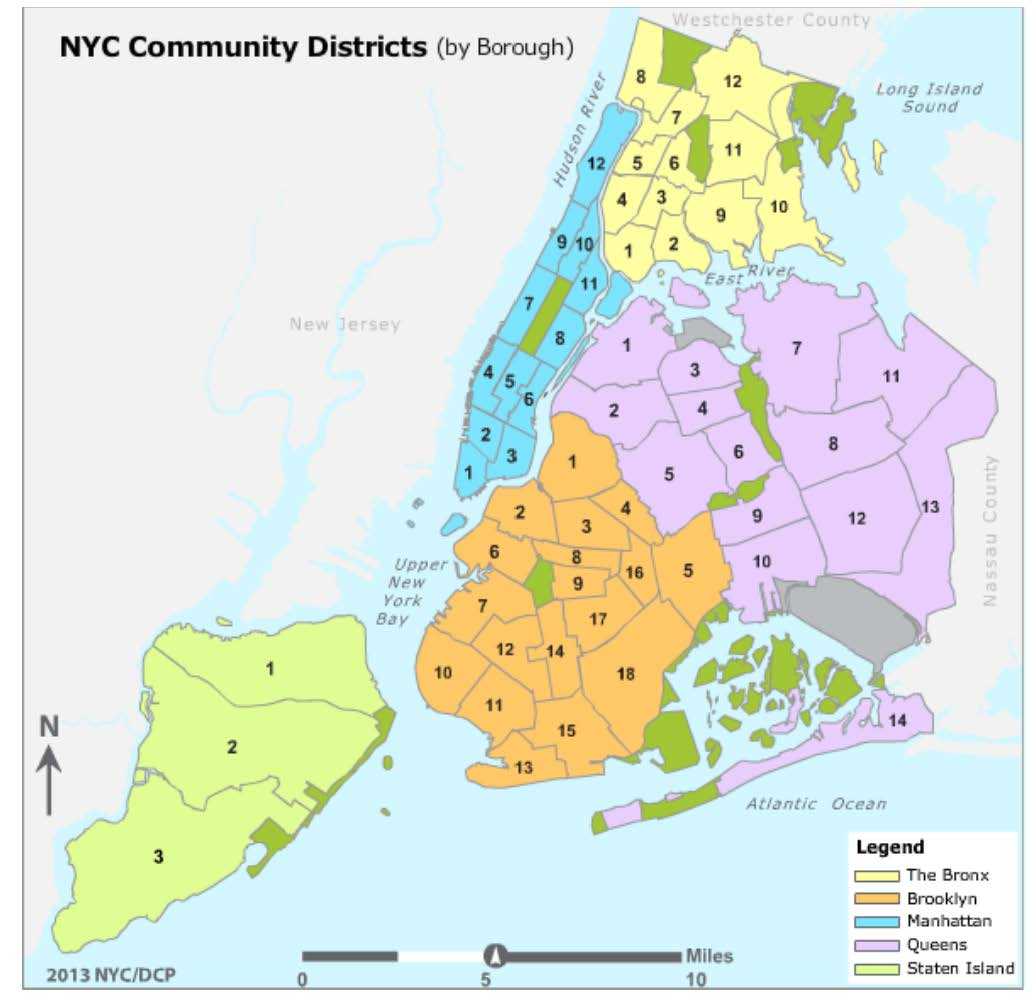

In [2]:
#source: http://www.nyc.gov/html/dcp/html/neigh_info/nhmap.shtml
from IPython.display import Image
Image(filename='NYCCommunityDistricts.jpg')

In [3]:
data311 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab8/district311.csv' , index_col=0 )

In [4]:
data311.columns=['Cell','CompType','Count']
data311.head()

,Cell,CompType,Count
1,01 BRONX,Adopt-A-Basket,2
2,01 BROOKLYN,Adopt-A-Basket,2
3,01 QUEENS,Adopt-A-Basket,1
4,01 STATEN ISLAND,Adopt-A-Basket,3
5,02 MANHATTAN,Adopt-A-Basket,7


In [5]:
october311 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab8/districtOct311.csv', index_col=0 )
october311.head()

,District,TimeCat,Count
1,0 Unspecified,0,451
2,01 BRONX,0,148
3,01 BROOKLYN,0,530
4,01 MANHATTAN,0,211
5,01 QUEENS,0,443


In [6]:
taxi = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab8/rides10.csv', index_col=0, header=None )
taxi.head()
#read taxi ridership as total:in/out/loop, weekday daytime: in/out/loop, weekend: in/out/loop

,1,2,3,4,5,6,7,8,9
0,,,,,,,,,
101,705249,718853,107192,266397,250444,43045,171843,178177,23312
102,1534603,1326793,281240,435155,446005,94385,464695,403180,84628
103,752835,681076,94379,139308,142534,17603,299242,247225,36754
104,1823404,1604493,394288,596048,561861,139295,517729,468108,116257
105,3325022,3319397,996507,1296649,1405798,461942,774673,734344,198710


In [7]:
#group and format the data into rectangular tables
def transDistCode(z):
    #parse text district code into numerical
    try:
        z0=int(z[0:2])
    except ValueError:
        z0=0
    if 'BRONX' in z:
        z0=200*(z0>0)+z0
    if 'QUEENS' in z:
        z0=400*(z0>0)+z0    
    if 'MANHATTAN' in z:
        z0=100*(z0>0)+z0
    if 'STATEN ISLAND' in z:
        z0=500*(z0>0)+z0
    if 'BROOKLYN' in z:
        z0=300*(z0>0)+z0  
    return z0    

import numbers
cells={}
cellinv={}
cellnum=0
complains={}
compinv={}
compnum=0
cx={}
cy={}
mh={}
X=numpy.zeros(shape=(72,200)) #all complains per district and category
OT=numpy.zeros(shape=(72,4)) #october total complains per district and time category (0-weekend, 1-weekday undef, 2-weekday daytime, 3-weekday-time-off)
TX=numpy.zeros(shape=(72,9)) #taxi ridership per district, direction (in/out/loop) and weekday (total,weekdays,weekends)
#Y1=numpy.zeros(shape=(72,1))
#Y2=numpy.zeros(shape=(72,1))
#Y3=numpy.zeros(shape=(72,1))
for i in data311.index:
    z0=transDistCode(data311.Cell[i]);
    if (z0>0)&(z0 in taxi.index):    
      if not (z0 in cells.keys()):
          cells[z0]=cellnum
          cellinv[cellnum]=z0
          cellnum+=1
      comp=data311.CompType[i] 
      if not (comp in complains.keys()):
          complains[comp]=compnum
          compinv[compnum]=comp
          compnum+=1
      X[cells[z0]][complains[comp]]=data311.Count[i]

X=X[0:cellnum,0:compnum]
for i in october311.index:
      z0=transDistCode(october311.District[i]);
      if z0 in cells.keys():
          OT[cells[z0],october311.TimeCat[i]]=october311.Count[i]
OT=OT[0:cellnum,:]

In [8]:
#regroup taxi data
for i in taxi.index:
      if i in cells.keys():
          for j in range(1,10):  
              TX[cells[i],j-1]=taxi[j][i]  
TX=TX[0:cellnum,:]

In [9]:
#cut districts with low activity (apparantly they all come in the end) 
cellnum=57
TX=TX[0:cellnum,:]
OT=OT[0:cellnum,:]
X=X[0:cellnum,:]

In [10]:
OT[0:5,:]
#number of complains in October 2013: weekends, weekdays undefined time, weekdays time-off, weekdays daytime

array([[  148.,   540.,   119.,   256.],
       [  530.,   587.,   697.,  1172.],
       [  443.,   476.,   496.,  1027.],
       [  273.,   716.,   376.,   939.],
       [  468.,   327.,   533.,   819.]])

In [11]:
TX[0:5,0:3]
#taxi rides in October 2013: incoming, outgoing, within a district

array([[  2.55000000e+03,   1.06120000e+04,   7.17000000e+02],
       [  1.80537000e+05,   2.61565000e+05,   5.85430000e+04],
       [  7.96920000e+04,   1.56319000e+05,   2.86710000e+04],
       [  7.40000000e+01,   1.10900000e+03,   4.40000000e+01],
       [  1.53460300e+06,   1.32679300e+06,   2.81240000e+05]])

In [12]:
#normalize and center complain structure (relative percentages of each complain type per district compared to average level)
XT=sum(X,1)
X=matrix(X)
for z in range(0,cellnum):
    X[z,:]=X[z,:]/XT[z]
m=mean(X,0)    
for i in range(0,compnum):
    X[:,i]=(X[:,i]-m[0,i])

In [13]:
X[0:5,0:3]
#normalized relative structure of 311 complains

matrix([[  1.13724441e-04,  -2.77289038e-03,   6.28017980e-03],
        [  2.18504532e-05,   1.94939035e-03,  -7.47451569e-04],
        [ -7.72426580e-06,   1.24900009e-03,  -7.09181382e-04],
        [  6.29063743e-05,  -1.87987809e-03,  -7.11151293e-04],
        [  2.70432633e-04,   9.21217809e-03,  -7.47451569e-04]])

In [14]:
#quantities to analyze
#taxi-related
T=TX[:,0]+TX[:,1]-TX[:,2] #total taxi ridership
TWE=(TX[:,6]+TX[:,7]-TX[:,8]) #total weekend ridership
TWD=TX[:,3]+TX[:,4]-TX[:,5] #total weekday ridership
L=TX[:,2]/T #fraction of in-district trips
WE=TWE/T #fraction of weekend ridership
OG=TX[:,4]/(TX[:,3]+TX[:,4]) #fraction of outgoing ridership during weekdays
#311-related
T311=sum(OT,1) #total 311 complains
TWE311=OT[:,0] #total weekend complains
WE311=TWE311/T311 #weekend fraction
WD311=OT[:,3] #weekday daytime complain count

# Excercise 1

Univariate linear regression: try to predict weekend/weekday/total taxi ridership in october based on a number of weekend/weekday/total 311 complains over the same month. Visualize the fit.

Hint: start from symmetrization for both - regressor and output variable before running the regressions so that intercept is not needed.

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     8.081
Date:                Sat, 07 Nov 2015   Prob (F-statistic):            0.00623
Time:                        23:50:36   Log-Likelihood:                -77.038
No. Observations:                  57   AIC:                             156.1
Df Residuals:                      56   BIC:                             158.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3551      0.125      2.843      0.0

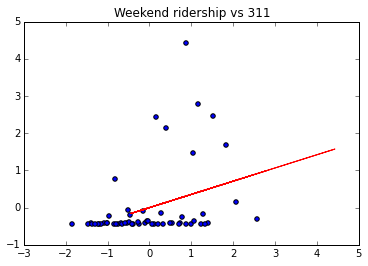

In [15]:
x1 = (TWE-mean(TWE))/std(TWE)
x2 = (TWD-mean(TWD))/std(TWD)
x3 = (T-mean(T))/std(T)
y1 = (TWE311-mean(TWE311))/std(TWE311)
y2 = (WD311-mean(WD311))/std(WD311)
y3 = (T311-mean(T311))/std(T311)

plt.scatter(y1,x1)
llm1 = smf.ols(formula='y1 ~ x1-1', data = {'y1':y1, 'x1':x1}).fit()
print(llm1.summary())
plt.plot(x1, llm1.predict(),'r')
plt.title ('Weekend ridership vs 311')

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     8.423
Date:                Sat, 07 Nov 2015   Prob (F-statistic):            0.00529
Time:                        23:50:36   Log-Likelihood:                -76.886
No. Observations:                  57   AIC:                             155.8
Df Residuals:                      56   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x2             0.3616      0.125      2.902      0.0

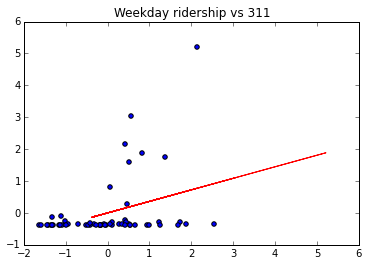

In [16]:
plt.scatter(y2,x2)
llm2 = smf.ols(formula='y2 ~ x2-1', data = {'y2':y2, 'x2':x2}).fit()
print(llm2.summary())
plt.plot(x2, llm2.predict(),'r-')
plt.title('Weekday ridership vs 311')

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.161
Date:                Sat, 07 Nov 2015   Prob (F-statistic):              0.286
Time:                        23:50:38   Log-Likelihood:                -80.295
No. Observations:                  57   AIC:                             162.6
Df Residuals:                      56   BIC:                             164.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x3             0.1425      0.132      1.077      0.2

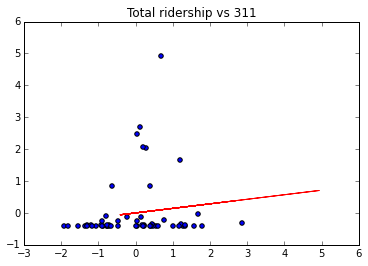

In [17]:
plt.scatter(y3,x3)
llm = smf.ols(formula='y3 ~ x3-1', data = {'y3':y3, 'x3':x3}).fit()
print(llm.summary())
plt.plot(x3, llm.predict(),'r')
plt.title ('Total ridership vs 311')

# Excercise 2.
Improve the predictions by adding more regressors: information about the structure of 311 complains.

Hint: consider principle component decomposition for X and use first dozen of PC's additional regressors. Consider log(taxi ridership/complain count) as an output variable.

0.948401030928


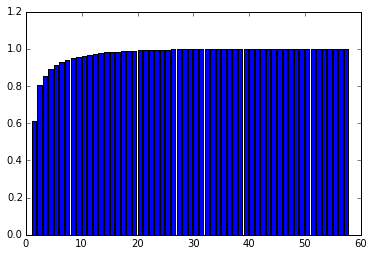

In [18]:
m = mean(X,0)
s = std(X,0)
X1 = 1.0*np.array(X)
for i in xrange(0,9):
    X1[:,i]=(X1[:,i]-m[0,i])/s[0,i]

U, s, Vt = np.linalg.svd(X) #singular value decomposition
V = Vt.T
#sort singular values
ind = np.argsort(s)[::-1] 
U = U[:, ind]
s = s[ind]
V = V[:, ind]
S = np.diag(s)
P=X*np.matrix(V)

sc=cumsum(s**2/sum(s**2))
plt.bar(range(1,(len(sc)+1)),sc)
print(sc[7])

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     47.00
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           8.10e-20
Time:                        23:50:42   Log-Likelihood:                -66.032
No. Observations:                  57   AIC:                             146.1
Df Residuals:                      50   BIC:                             160.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
P1             5.9083      1.053      5.613      0.0

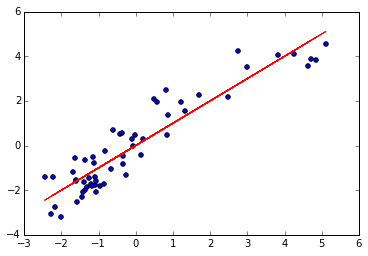

In [19]:
pc=pd.DataFrame(P[:,0:7])
pc.columns=['P1','P2','P3','P4','P5','P6','P7']
Y = log(TWE/TWE311)
Y = Y-mean(Y)
pc['Y'] = Y
lm = smf.ols(formula='Y ~ P1+P2+P3+P4+P5+P6+P7-1', data=pc).fit()
print(lm.summary())
plt.scatter(lm.predict(), pc.Y)
plt.plot(lm.predict(), lm.predict(), 'r')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     62.80
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           7.92e-21
Time:                        23:50:43   Log-Likelihood:                -68.141
No. Observations:                  57   AIC:                             146.3
Df Residuals:                      52   BIC:                             156.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
P1             5.9083      1.071      5.516      0.0

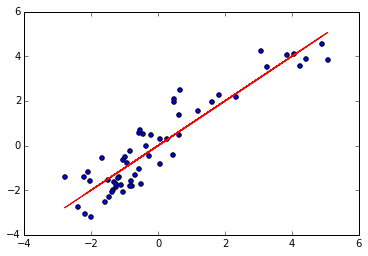

In [20]:
lm = smf.ols(formula='Y ~ P1+P2+P3+P4+P5-1', data=pc).fit()
print(lm.summary())
plt.scatter(lm.predict(), pc.Y)
plt.plot(lm.predict(), lm.predict(), 'r')

# Excercise 3.
Predict percentage of weekend taxi ridership and weekday outgoing ridership vs 311 complain structure.

Hint: try both - linear (after symmetrization; without intercept) and logistic regression (without symmetrization; notice that the output variable is between 0 and 1).

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.316
Date:                Sat, 07 Nov 2015   Prob (F-statistic):              0.256
Time:                        23:56:16   Log-Likelihood:                -80.217
No. Observations:                  57   AIC:                             162.4
Df Residuals:                      56   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1516      0.132      1.147      0.2

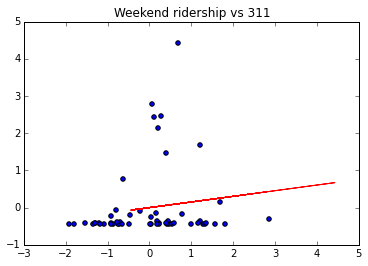

In [25]:
x1 = (TWE-mean(TWE))/std(TWE)
y3 = (T311-mean(T311))/std(T311)

plt.scatter(y3,x1)
llm1 = smf.ols(formula='y3 ~ x1-1', data = {'y3':y3, 'x1':x1}).fit()
print(llm1.summary())
plt.plot(x1, llm1.predict(),'r')
plt.title ('Weekend ridership vs 311')

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5812
Date:                Sat, 07 Nov 2015   Prob (F-statistic):              0.449
Time:                        23:58:46   Log-Likelihood:                -80.585
No. Observations:                  57   AIC:                             163.2
Df Residuals:                      56   BIC:                             165.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x4            -0.1013      0.133     -0.762      0.4

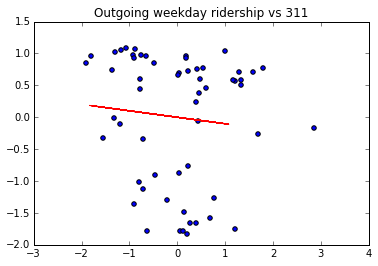

In [28]:
x4 = (OG-mean(OG))/std(OG)
y3 = (T311-mean(T311))/std(T311)

plt.scatter(y3,x4)
llm1 = smf.ols(formula='y3 ~ x4-1', data = {'y3':y3, 'x4':x4}).fit()
print(llm1.summary())
plt.plot(x4, llm1.predict(),'r')
plt.title ('Outgoing weekday ridership vs 311')

In [ ]:
logit = smf.logit('y ~ x1-1', data = {'y':y3, 'x1':x1}).fit()
print(logit.summary())
le = logit.predict()
plt.figure()
plt.scatter(TWE, T311,c=le,s=30,lw=0)

# Excercise 4.
Verify the models using cross-validation - repeat the following procedure 10 times: randomly select approximately 65% of the data points for the training set and compute R2 over the rest of the points considered as test set. Report average and standard deviation of R2 for all the tries.

Perform feature selection (naive one using p-values or forward step-wise if you have time) in order to improve the cross-validation result.

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.316
Date:                Sun, 08 Nov 2015   Prob (F-statistic):              0.256
Time:                        00:25:35   Log-Likelihood:                -80.217
No. Observations:                  57   AIC:                             162.4
Df Residuals:                      56   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1516      0.132      1.147      0.2

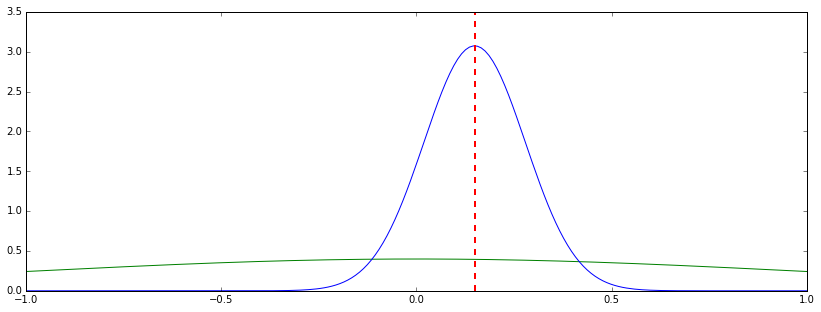

In [42]:
w_prior = 0
sigma2_prior = 1 

#Regression 
model1 = smf.ols(formula='y3 ~ x1-1', data = {'y3':y3, 'x1':x1}).fit()
print(model1.summary())

sigma2 = np.mean((y3-model1.predict())**2)

#estimate parameters of the posterior
sigma2_w = (sum(x1**2)/sigma2+1/sigma2_prior)**-1
w_est = (sum(x1*y3)/sigma2+w_prior/sigma2_prior)*sigma2_w
dist = stats.norm(loc=w_est,scale=sigma2_w**0.5)
dist_prior = stats.norm(loc=w_prior,scale=sigma2_prior**0.5)
print('Posterior distr = N({0},{1}^2)'.format(w_est,sigma2_w**0.5))

#Plotting
x=np.linspace(-1,1,200)
plt.figure(figsize = (14,5))
plt.plot(x,dist_prior.pdf(x),color='g')
plt.plot(x,dist.pdf(x),color='b')
plt.axvline(w_est, color='r', ls='--', lw=2.0)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


 [-----------------100%-----------------] 10 of 10 complete in 0.3 secSample mean=0.130114909248,std=0.225958248791


(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.05712938,  0.06295114,  0.0687729 ,  0.07459466,  0.08041642,
         0.08623817,  0.09205993,  0.09788169,  0.10370345,  0.10952521,
         0.11534696,  0.12116872,  0.12699048,  0.13281224,  0.13863399,
         0.14445575,  0.15027751,  0.15609927,  0.16192103,  0.16774278,
         0.17356454,  0.1793863 ,  0.18520806,  0.19102982,  0.19685157,
         0.20267333]),
 <a list of 25 Patch objects>)

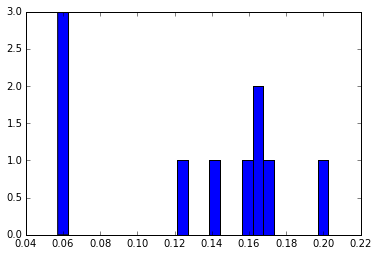

In [44]:
import pymc3 as pm
with pm.Model() as model1: #introduce a PyMC3 simulation framework
    #for a normal prior
    w = pm.Normal('w', mu=0, sd=1) 
    #set up the likelohood function of the model
    y_est = w * x1
    likelihood = pm.Normal('y', mu=y_est, sd=sigma2**0.5, observed=y3)
    #as well as the model parameters
    start = pm.find_MAP() #use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    step = pm.NUTS(state=start)
    trace = pm.sample(10, step, start=start, progressbar=True) #perform 10 iteration saving them to <trace>
    
sample=trace.w[0:10]
#output sample parameters
w_est=np.mean(sample) 
sigma_w=np.std(sample)
print('Sample mean={},std={}'.format(w_est,sigma_w**0.5))

plt.hist(sample,25)